In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os
import PlaceCellAnalysis as pc
import pickle

os.sys.path.append('../')
import utilities as u
import preprocessing as pp
import behavior as b
import logistic_regression as lr
import matplotlib.gridspec as gridspec

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression


%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
df = pp.load_session_db()
df = df[df['RewardCount']>30]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
tracks = 'TwoTower_noTimeout|TwoTower_Timeout|Reversal_noTimeout|Reversal|TwoTower_foraging'
df = df[df['Track'].str.contains(tracks,regex=True)]


G:\My Drive\VR_Data\TwoTower\behavior.sqlite


In [108]:
mouse = '4222154.1'
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse

,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
1717,4222154.1,08_04_2019,1,TwoTower_foraging,120,1,CA1,2019-04-08,G:\My Drive\VR_Data\TwoTower\4222154.1\08_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222154.1\08_04_2...,G:\My Drive\2P_Data\TwoTower\4222154.1\08_04_2...
1741,4222154.1,10_04_2019,4,TwoTower_foraging,120,1,CA1,2019-04-10,G:\My Drive\VR_Data\TwoTower\4222154.1\10_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222154.1\10_04_2...,G:\My Drive\2P_Data\TwoTower\4222154.1\10_04_2...
1762,4222154.1,12_04_2019,2,TwoTower_foraging,95,1,CA1,2019-04-12,G:\My Drive\VR_Data\TwoTower\4222154.1\12_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222154.1\12_04_2...,G:\My Drive\2P_Data\TwoTower\4222154.1\12_04_2...
1782,4222154.1,14_04_2019,2,TwoTower_foraging,96,1,CA1,2019-04-14,G:\My Drive\VR_Data\TwoTower\4222154.1\14_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222154.1\14_04_2...,G:\My Drive\2P_Data\TwoTower\4222154.1\14_04_2...
1797,4222154.1,15_04_2019,2,TwoTower_foraging,102,1,CA1,2019-04-15,G:\My Drive\VR_Data\TwoTower\4222154.1\15_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222154.1\15_04_2...,G:\My Drive\2P_Data\TwoTower\4222154.1\15_04_2...
1810,4222154.1,16_04_2019,2,TwoTower_foraging,71,1,CA1,2019-04-16,G:\My Drive\VR_Data\TwoTower\4222154.1\16_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222154.1\16_04_2...,G:\My Drive\2P_Data\TwoTower\4222154.1\16_04_2...
1819,4222154.1,17_04_2019,2,TwoTower_foraging,78,1,CA1,2019-04-17,G:\My Drive\VR_Data\TwoTower\4222154.1\17_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222154.1\17_04_2...,G:\My Drive\2P_Data\TwoTower\4222154.1\17_04_2...
1828,4222154.1,18_04_2019,2,TwoTower_foraging,70,1,CA1,2019-04-18,G:\My Drive\VR_Data\TwoTower\4222154.1\18_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222154.1\18_04_2...,G:\My Drive\2P_Data\TwoTower\4222154.1\18_04_2...
1836,4222154.1,19_04_2019,2,TwoTower_foraging,79,1,CA1,2019-04-19,G:\My Drive\VR_Data\TwoTower\4222154.1\19_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222154.1\19_04_2...,G:\My Drive\2P_Data\TwoTower\4222154.1\19_04_2...


In [109]:
sess = df_mouse.iloc[-3]
fname = os.path.join("G:\\My Drive\\Figures\\TwoTower\\LogReg_smooth",mouse,"%s_%d_Xhat.pkl" % (sess['DateFolder'],sess['SessionNumber']))


In [110]:
VRDat,C, S, A = pp.load_scan_sess(sess)


num aberrant ttls 0.0
31805 (31805,) (31805, 21) 105737
frame diff 0


In [111]:
trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,VRDat['pos']._values,VRDat['tstart']._values,VRDat['teleport']._values)
effMorph = trial_info['morphs']+trial_info['bckgndJitter']+trial_info['towerJitter']
effMorph = (effMorph+.2)/1.4

In [112]:
with open(fname,"rb") as f:
    d = pickle.load(f)
    Xhat = d['Xhat']

In [113]:
print(Xhat.shape)

(31805, 44)


In [114]:

num,den = Xhat[:,:22].sum(axis=1),Xhat[:,22:].sum(axis=1)
rat = np.log(num)-np.log(den)


C:\Users\mplitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\mplitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until


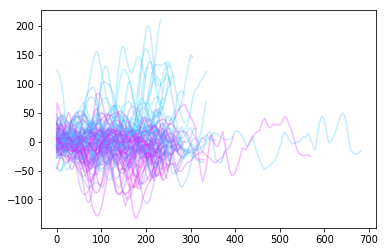

In [115]:
f,ax = plt.subplots()
for ind,(tstart,tstop) in enumerate(zip(tstart_inds.to_list(),teleport_inds.tolist())):
    ax.plot(rat[tstart:tstop],color=plt.cm.cool(effMorph[ind]),alpha=.3)
    

In [116]:
rat_trial_mat = u.make_pos_bin_trial_matrices(rat,VRDat.pos._values,VRDat['tstart']._values,VRDat['teleport']._values,mat_only=True,bin_size=10)

((<Figure size 432x288 with 1 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x21c80cb50f0>),
 (<Figure size 1440x360 with 5 Axes>,
  array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000021C82BAAFD0>,
        dtype=object)),
 (<Figure size 720x720 with 2 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x21c83963c18>),
 (<Figure size 432x288 with 1 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x21c83995ac8>))

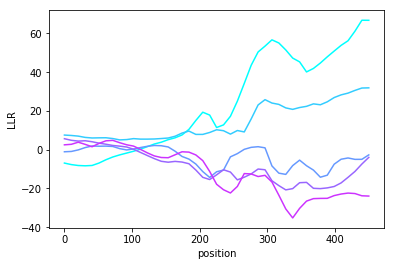

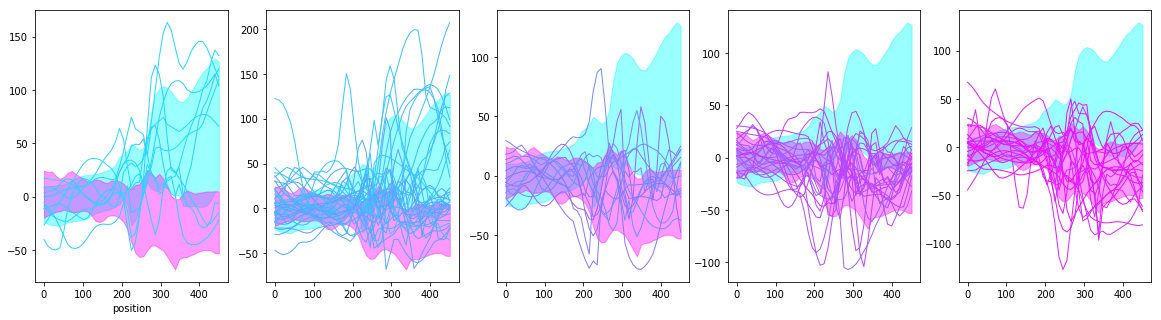

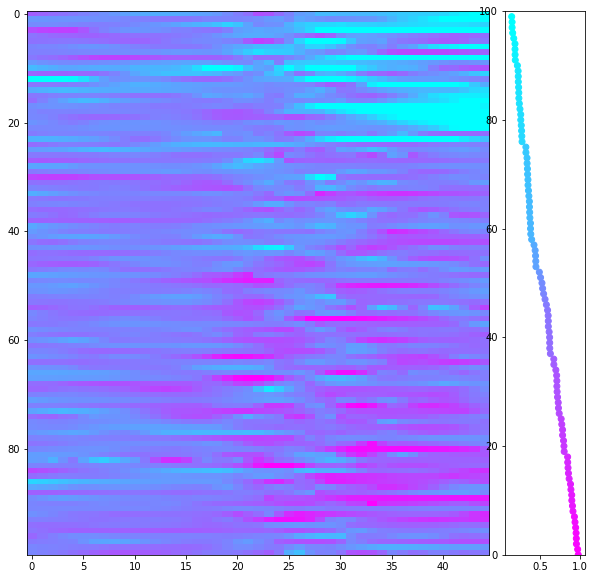

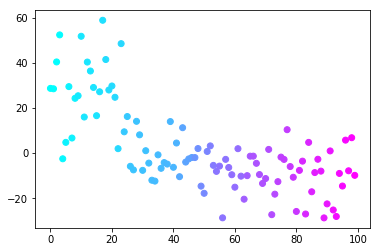

In [117]:
lr.plot_llr(rat_trial_mat,effMorph)

(100, 45)


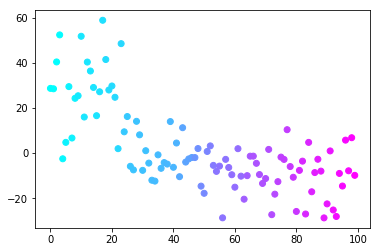

In [118]:
f,ax = plt.subplots()
print(rat_trial_mat.shape)
ax.scatter(np.arange(effMorph.shape[0]),rat_trial_mat.mean(axis=-1)[np.argsort(effMorph)],c=effMorph[np.argsort(effMorph)],cmap='cool')

(array([0.01026104, 0.01254127, 0.03762381, 0.02052208, 0.00912092,
        0.00342035, 0.01140116, 0.00342035, 0.00228023, 0.00342035]),
 array([-28.74430359, -19.97326267, -11.20222175,  -2.43118084,
          6.33986008,  15.110901  ,  23.88194191,  32.65298283,
         41.42402375,  50.19506466,  58.96610558]),
 <a list of 10 Patch objects>)

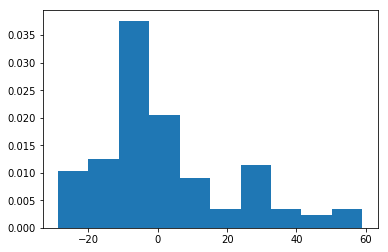

In [119]:
f,ax = plt.subplots()
ax.hist(rat_trial_mat.mean(axis=-1),bins=10,density=True)